# Lab session week 3: Scikit-Image

This week, you will learn some computer vision techniques that you will use in the final assignment of this course to gather features from a data set of images.

Most of the information is covered in this week's slides. Please write code for the following exercises.

In [1]:
# import skimage as si 
# import numpy as np
# from skimage import io

# image = np.array([[0,0,1,1], [0,1,0,1], [ (255,0,0), (0,255,0), (0,0,255), (255,255,255)]])
# io.imshow(image)

In [2]:
import numpy as np
import skimage as ski
from skimage import io, filters, transform, color
import matplotlib
import matplotlib.pyplot as plt
import os


def display(np_image):
    """
    This is a display function that we have added to show numpy images at full size
    If you pass in an image with 3 channels, it will be displayed in RGB
    If you passn in an image with 1 channel, it will be displayed in grayscale
    """
    dpi = matplotlib.rcParams['figure.dpi']
    if len(np_image.shape) == 3:
        height, width, depth = np_image.shape
    else:
        height, width = np_image.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axis that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')
    
    # Display the image in either RGB or grayscale (depending on the amount of dimensions)
    if (len(np_image.shape) >= 3):
        ax.imshow(np_image)
    else:
        ax.imshow(np_image, cmap='gray')

    plt.show()

## Exercise 1: Where's (scary) Wally?
Where's Wally? is a British series of children's puzzle books. The books consist of a series of detailed double-page spread illustrations depicting dozens or more people doing a variety of amusing things at a given location. Readers must find a character named Wally hidden in the group.

In this exercise you will see a cropped version of one of those puzzles: scary Wally. This image has been cut out of the original puzzle and several computer vision operations have been applied to it. 

The goal of this assignment is:
- Find Wally **by hand** in the large image
- Cut Wally out of the original image
- Apply the same transformations that have been applied to scary Wally in order to create exactly the same image

Are you able to find Wally and achieve the exact same result as scary Wally?

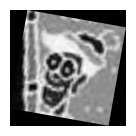

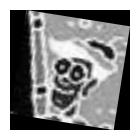

In [3]:
scary = io.imread(os.path.join('dataset_week3', 'scaryWally.jpg'))
display(scary)
# io.imshow(scary)

orig = io.imread(os.path.join('dataset_week3', 'wally.jpg'))
cropped = orig[70:115,-330:-290]                            # crop the image
cropped = ski.transform.resize(cropped, (105,105))          # resize the image
cropped = ski.color.rgb2gray(cropped)                       # convert color to grayscale
cropped = 1- cropped                                        # invert the grayscale color
cropped = np.fliplr(cropped)                                # flip the image horizontally
cropped = ski.transform.rotate(cropped, -9, resize=True)    # rotate the image

display(cropped)
# display(orig)

## Exercise 2: Changing colors
Evert Duipmans recently bought a Ferrari. He has been driving the car for a couple of months now, but somehow he is not so happy with the color of the car. Luckily, when he is driving the car he can't see the color, but everytime he looks at a picture of the car he gets annoyed. Can you help him out and write a function that changes the yellow Ferrari into a red one?

**Hints:**
- There are colorspaces that could be suitable for changing colors
- Displaying images is only possible in RGB

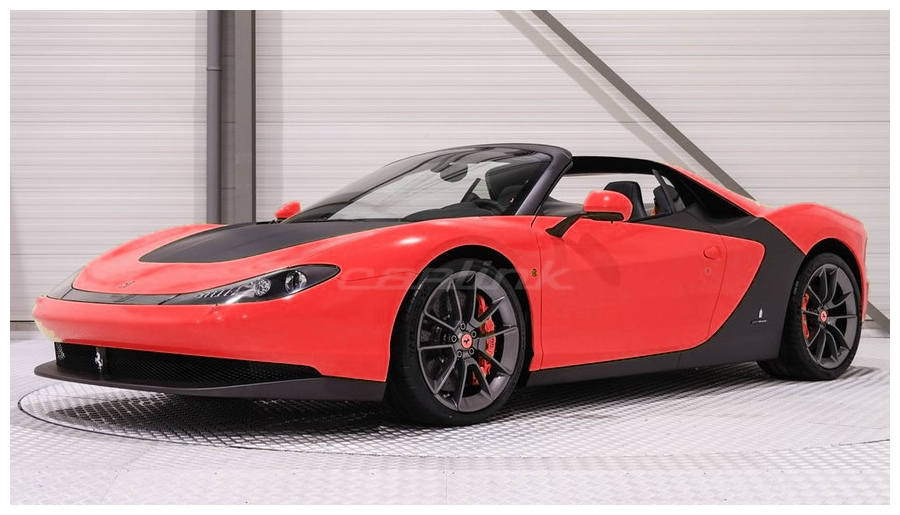

In [4]:
img = io.imread(os.path.join('dataset_week3', 'ferrari.jpg'))
# display(img)
img = color.rgb2hsv(img)

hue_min = 0.1
hue_max = 0.2

mask = ((img[:,:,0] >= hue_min) & (img[:,:,0] <= hue_max))
img[mask, 0] = 0


img = color.hsv2rgb(img)
display(img)

## Exercise 3: Counting money
In this exercise, you will build an algorithm that is able to count (and sum) euros. The ```simple``` folder contains 25 images of euro coins in different positions and different rotations. It is your goal to write an algorithm that analyzes the image and tells us how much money is displayed in the image.

We also provided the ```simple_totals.csv``` file. This file contains the amounts for each of the images. Please use this file to check if your algorithm works correctly.

**How to approach this problem?**
1. Use Scikit-Image to load an image
2. Use filters to make the image suitable for binarization
3. Binarize the image and apply morphological operations to fill holes and remove noise
4. Label the image (create blobs)
5. Collect features from the labels
6. Write logic (based on the features) to classify each coin
7. Combine everything into a function, so that you can predict the total amount of money on each image

**Hints:**
- The scaling factor on all the images is the same: each type of coin has exactly the same dimensions in every image.
- There are no differences in contrast and brightness between images
- You don't need any machine learning algorithms for this problem, just simple if-statements will do.

In [5]:
# Read the total amount of money of all of the images
outcomes = np.genfromtxt(os.path.join('dataset_week3/', 'simple_totals.csv'))


threshold = 3
def get_coin_value(width, height):
    average = (width+height)/2

    # 0.01 is equivalent to 1 cent, 1.0 is €1
    if average >= (191.5 - threshold) and average <= (191.5 + threshold):
        return 0.1
    elif average >= (207 - threshold) and average <= (207 + threshold):
        return 0.05
    elif average >= (221 - threshold) and average <= (221 + threshold):
        return 1.0
    elif average >= (214.5 - threshold) and average <= (214.5 + threshold):
        return 0.20
    elif average >= (183 - threshold) and average <= (183 + threshold):
        return 0.02
    elif average >= (250 - threshold) and average <= (250 + threshold):
        return 2.0
    elif average >= (233.5 - threshold) and average <= (233.5 + threshold):
        return 0.5
    elif average >= (158 - threshold) and average <= (158 + threshold):
        return 0.01
    else:
        return 0

simple_files = os.listdir('dataset_week3/simple')
# print(simple_files)

coins = io.imread(os.path.join('dataset_week3/simple', '0.png'))

for file in simple_files[:10]:
    total_amount = 0.0
    index = simple_files.index(file)

    coins = io.imread(os.path.join('dataset_week3/simple', file))

    #grayscale
    coins = color.rgb2gray(coins)
    coins = 1-coins

    p2, p98 = np.percentile(coins, (2, 90))  # Get the 2nd and 98th percentile intensities
    high_contrast = ski.exposure.rescale_intensity(coins, in_range=(p2, p98))  # Rescale intensities between p2 and p98

    #get binary
    # binary = 1-coins
    thresh = filters.threshold_otsu(high_contrast)
    binary = high_contrast > thresh

    closed_img = ski.morphology.closing(binary, ski.morphology.disk(3))
    cleaned_img = ski.morphology.opening(closed_img, ski.morphology.disk(3))


    #label
    label_image = ski.measure.label(cleaned_img)
    blobs = ski.measure.regionprops(label_image)
    # fig, ax = plt.subplots()
    # ax.imshow(inverted_binary, cmap='gray')

    for blob in blobs:
        if blob.area > 50:
            min_row, min_col, max_row, max_col = blob.bbox
            width = max_col-min_col
            height = max_row-min_row

            # rect = plt.Rectangle((min_col, min_row), width, height, fill = False, edgecolor='red', linewidth=2)
            # ax.add_patch(rect)

            coin_value = get_coin_value(width=width, height=height)
            total_amount += coin_value


    # display(coins)

    print(f"Image {index} has total amount: €{outcomes[index]}")
    print('calculated total is: €', round(total_amount, 2))


Image 0 has total amount: €4.75
calculated total is: € 4.75
Image 1 has total amount: €8.8
calculated total is: € 8.8
Image 2 has total amount: €5.81
calculated total is: € 8.6
Image 3 has total amount: €8.66
calculated total is: € 10.78
Image 4 has total amount: €6.49
calculated total is: € 10.38
Image 5 has total amount: €5.73
calculated total is: € 3.96
Image 6 has total amount: €7.96
calculated total is: € 9.17
Image 7 has total amount: €9.19
calculated total is: € 8.07
Image 8 has total amount: €10.37
calculated total is: € 8.14
Image 9 has total amount: €4.14
calculated total is: € 9.07


In [6]:
import skimage.io as io
from skimage import exposure
from skimage import filters, morphology
from skimage import measure
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.measure import regionprops


treshold = 5

# Function to determine coin value based on width and height
def get_coin_value(width, height):
    average = (width + height) / 2
    if average >= 191.5 - treshold and average <= 191.5 + treshold:
        return 0.10  # 10 cent
    elif average >= 207 - treshold and average <= 207 + treshold:
        return 0.05  # 5 cent
    elif average >= 221 - treshold and average <= 221 + treshold:
        return 1.00  # 1 euro
    elif average >= 214.5 - treshold and average <= 214.5 + treshold:
        return 0.20  # 20 cent
    elif average >= 183 - treshold and average <= 183 + treshold:
        return 0.02  # 2 cent
    elif average >= 250 - treshold and average <= 250 + treshold:
        return 2.00  # 2 euro
    elif average >= 233.5 - treshold and average <= 233.5 + treshold:
        return 0.50  # 50 cent
    elif average >= 158 - treshold and average <= 158 + treshold:
        return 0.01  # 1 cent
    else:
        return 0  # If it doesn't match any coin size, return 0

def calculate_total_value(coins):
    total_value = 0  # Initialize the total value of coins
    # load image using scikit-image
    img = io.imread(os.path.join('dataset_week3/simple', coins))

    # gray scale image
    img_gray = rgb2gray(img)
    img_converted = 1 - img_gray

    # Apply contrast stretching for high contrast
    p2, p98 = np.percentile(img_converted, (2, 90))  # Get the 2nd and 98th percentile intensities
    high_contrast = exposure.rescale_intensity(img_converted, in_range=(p2, p98))  # Rescale intensities between p2 and p98

    # Display the high contrast image
    # display(high_contrast)

    # Convert to binary image using Otsu's thresholding method
    threshold = filters.threshold_otsu(high_contrast)

    binary_image = high_contrast > threshold  # Binarize the image

    # Apply morphological closing to fill small holes
    closed_image = morphology.closing(binary_image, morphology.disk(3))  # Use a disk-shaped structuring element

    # Apply morphological opening to remove noise
    cleaned_image = morphology.opening(closed_image, morphology.disk(3))  # Use a disk-shaped structuring element

    labels = measure.label(cleaned_image)  # Each connected component (blob) gets a unique label

    # Get the properties of labeled blobs
    blobs = regionprops(labels)

    # Visualize the blobs by drawing a bounding box around them
    # fig, ax = plt.subplots()
    # ax.imshow(binary_image, cmap='gray')

    for blob in blobs:
        # Filter out small blobs based on the area
        if blob.area > 50:  # Threshold to ignore very small blobs
            minr, minc, maxr, maxc = blob.bbox  # Get bounding box coordinates
            rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)  # Draw rectangle around blob
            # ax.add_patch(rect)

    # plt.show()

    for blob in blobs:
        # Get the bounding box coordinates (min_row, min_col, max_row, max_col)
        minr, minc, maxr, maxc = blob.bbox

        # Calculate the width and height
        width = maxc - minc  # Width of the rectangle
        height = maxr - minr  # Height of the rectangle

        # Get the value of the coin based on width and height
        coin_value = get_coin_value(width, height)
        
        # Add the coin value to the total
        total_value += coin_value

    # Print the total value of all detected coins
    print(f"Total value of coins: {total_value:.2f} Euro")

# loop from 0 to 24 and replace the number in the string with the counter
for i in range(24):
    image_filename = f"{i}.png"
    print(f"Image {i} has total amount: €{outcomes[i]}")
    calculate_total_value(image_filename)

Image 0 has total amount: €4.75
Total value of coins: 4.75 Euro
Image 1 has total amount: €8.8
Total value of coins: 8.80 Euro
Image 2 has total amount: €5.81
Total value of coins: 5.81 Euro
Image 3 has total amount: €8.66
Total value of coins: 8.66 Euro
Image 4 has total amount: €6.49
Total value of coins: 6.49 Euro
Image 5 has total amount: €5.73
Total value of coins: 5.73 Euro
Image 6 has total amount: €7.96
Total value of coins: 7.96 Euro
Image 7 has total amount: €9.19
Total value of coins: 9.19 Euro
Image 8 has total amount: €10.37
Total value of coins: 10.37 Euro
Image 9 has total amount: €4.14
Total value of coins: 4.14 Euro
Image 10 has total amount: €8.6
Total value of coins: 8.60 Euro
Image 11 has total amount: €14.78
Total value of coins: 10.78 Euro
Image 12 has total amount: €10.38
Total value of coins: 10.38 Euro
Image 13 has total amount: €3.96
Total value of coins: 3.96 Euro
Image 14 has total amount: €9.17
Total value of coins: 9.17 Euro
Image 15 has total amount: €8.0